## Data preparation and sanitization

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

from core.utils.preprocessing import df_to_xy

# Read and sanitize the data
#df = pd.read_excel("../data/t00/data.xls")

df = pd.read_excel("../data/t00/own_data.xls")
df = df.dropna()


x, y = df_to_xy(df, fuse_risk=True, centered=False, min_target=5, max_target=190)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200


#### Benchmark

In [3]:
from core.utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


**Keras Model**

In [4]:
from core.models.deep import KerasModel, loss_tf, gain_tf

Using TensorFlow backend.


In [5]:
import os, sys


In [6]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [7]:
from core.models import EMModel, RandomModel

**Convervative model**

In [8]:
from core.models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [10]:
from core.models import RandomModel

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from core.models import ClusterModel, ClusterExtModel

In [13]:
from sklearn.neural_network import MLPClassifier

** Acceptance model **

In [14]:
from core.models import AcceptanceModel

** Data augmentation **

In [15]:
from core.utils.data_augmentation import DACombine

**Baseline models**

In [16]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    "random": RandomModel(MAX_GAIN),
    "conservative": ConservativeModel(MAX_GAIN),
    "em": EMModel(MAX_GAIN),
    "svc": SVC(gamma='auto'),
    "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
em,26.060606,0.244481,23.372085,1.000000,860.000000,1446.363636,0.103030
svc,39.030303,0.363043,21.122622,0.184174,1288.000000,3324.545455,0.254545
random,60.735803,0.568098,39.750014,0.154264,2004.281486,5376.514618,0.387879
linear_regressor,65.194514,0.634418,24.064925,0.177789,2151.418976,6203.788141,0.563636
conservative,110.757576,0.939179,110.757576,1.000000,3655.000000,13453.181818,0.000000


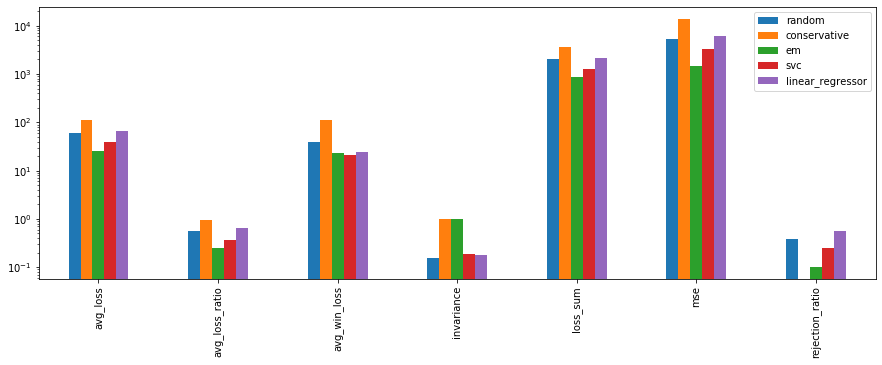

In [17]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [18]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

# results = {key: process_benchmark_cv(model, x, y.ravel(), ) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None], shuffle=True)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
meanshift_ext,25.454545,0.222094,21.239268,0.184319,840.0,1396.363636,0.084848
affinity_ext,31.575758,0.281212,23.032061,0.168340,1042.0,2076.666667,0.139394
meanshift,34.793939,0.330445,29.890661,0.179483,1148.2,2059.957576,0.096970
affinity,39.412121,0.382829,28.828374,0.169431,1300.6,2677.266667,0.175758


In [19]:
pd.DataFrame(results_std).T

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
affinity,10.938336,0.078210,4.286772,0.023156,360.965095,1471.444411,0.118143
meanshift,6.800529,0.080779,3.246857,0.028889,224.417468,819.304924,0.084087
affinity_ext,11.945507,0.113535,7.347650,0.020611,394.201725,1229.598479,0.097253
meanshift_ext,5.173749,0.064709,4.275093,0.027623,170.733711,444.183794,0.058289


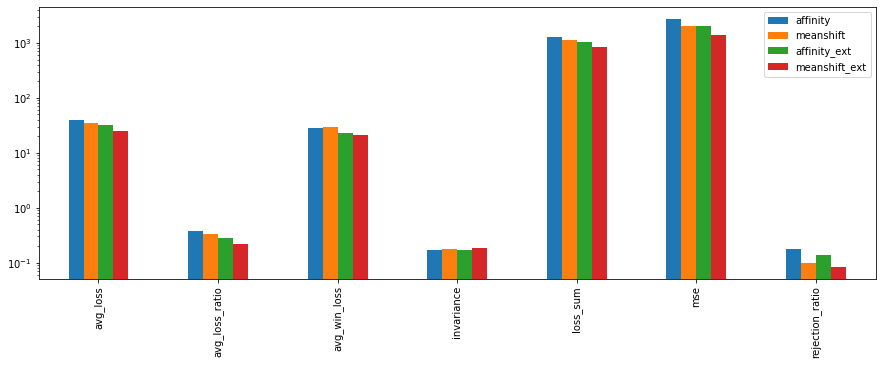

In [20]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [21]:
benchmark_models = {
    'em': EMModel(),
    # Regression
    #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    #"nn_regression_hiddenless": KerasModel(no_hidden_layer=True),
#     "nn_regression": KerasModel(batch_size=30, epochs=200),
    'acceptance_model': AcceptanceModel(),   #step=10, zero_one=True),
    # Classification
    "random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
logistic_regression,24.606061,0.235065,20.143902,0.203237,812.0,1397.272727,0.109091
em,26.060606,0.244481,23.372085,1.000000,860.0,1446.363636,0.103030
em_da2,37.454545,0.336803,36.672340,1.000000,1236.0,2136.363636,0.084848
random_forest,37.848485,0.365332,21.802674,0.186101,1249.0,2902.878788,0.254545
acceptance_model,57.424242,0.529464,38.977679,0.190954,1895.0,5132.575758,0.369697
logistic_regression_da2,68.000000,0.634051,35.470652,0.137675,2244.0,6774.242424,0.496970
random_forest_da2,70.000000,0.646054,40.684895,0.138535,2310.0,6990.000000,0.496970
acceptance_model_da2,88.242424,0.768984,65.430736,0.142413,2912.0,10050.909091,0.593939


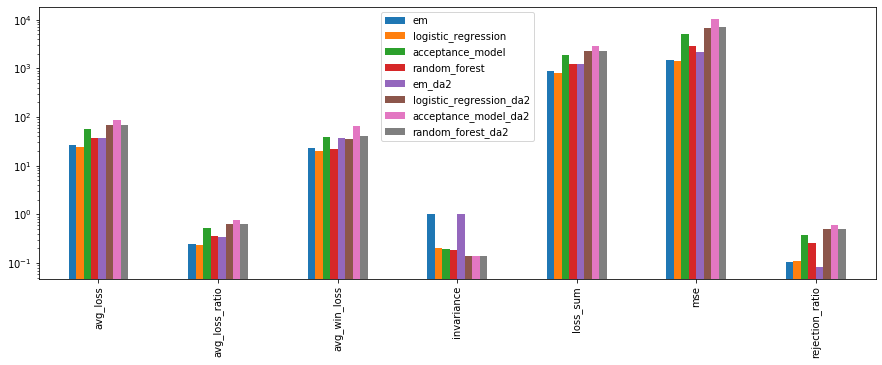

In [22]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [23]:
from sklearn.svm import SVR
benchmark_models = {
    'em': EMModel(),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    'svc': SVC(gamma='auto'),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    'acceptance_model_svr': AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=1), step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
logistic_regression,24.606061,0.235065,20.143902,0.203237,812.0,1397.272727,0.109091
em,26.060606,0.244481,23.372085,1.000000,860.0,1446.363636,0.103030
acceptance_model_svr,29.515152,0.282547,24.787500,0.219095,974.0,1644.545455,0.127273
svc,39.030303,0.363043,21.122622,0.184174,1288.0,3324.545455,0.254545
acceptance_model,43.151515,0.403938,33.533482,0.184673,1424.0,3160.909091,0.206061


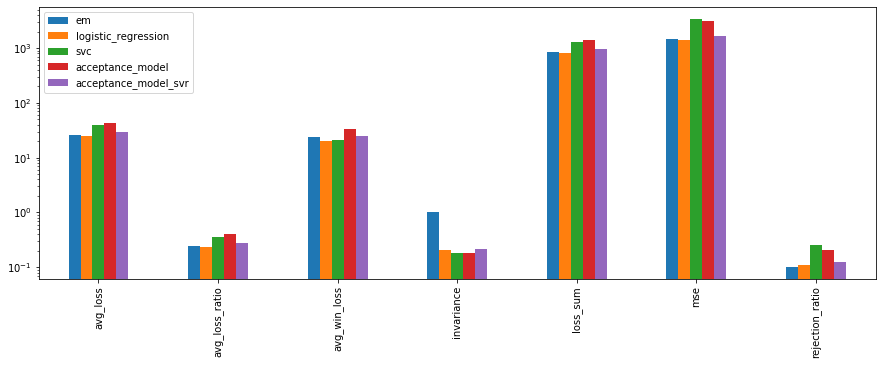

In [24]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

In [25]:
from sklearn.svm import SVR
benchmark_models = {
    'mlp': MLPClassifier(
        hidden_layer_sizes=(1024,), max_iter=1024, solver='sgd',
        learning_rate='adaptive',
        activation='relu',
    ),
    'log_reg': LogisticRegression(multi_class='auto', solver='lbfgs'),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1024) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1024) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fr

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
mlp,26.666667,0.250542,23.529557,0.870136,880.0,1506.969697,0.109091
log_reg,30.000000,0.276760,23.326437,0.271884,990.0,1960.303030,0.139394


In [26]:
from core.models.metrics import avg_gain_ratio
clf = ClusterExtModel(base_model="affinity")
xTrain, xTest, yTrain, yTest = train_test_split(x, y)
clf.fit(xTrain, yTrain)

# clf = EMModel()
xTrain, xTest, yTrain, yTest = train_test_split(x, y)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTrain)

print(np.unique(yPred))

print("acc: ", avg_gain_ratio(yTrain, yPred))
yPred = clf.predict(xTest)
print(np.unique(yPred))
print("val_acc: ", avg_gain_ratio(yTest, yPred))

[ 50.  75. 100. 105. 150. 190.]
acc:  0.6671093512381515
[ 50.  75. 100. 105. 150. 190.]
val_acc:  0.64670662071577
